In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project_images/Food-101-minimized/

/content/drive/MyDrive/project_images/Food-101-minimized


In [ ]:
%ls


logistic_regression_model.pkl  test/  train/


In [3]:
import os
import cv2
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

def histogram_equalization(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Merge the equalized channel with the original color channels
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = equalized
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    return img_output

def color_normalization(image):
    # Convert the image to floating-point format
    img_float = image.astype(float)

    # Normalize each channel to have zero mean and unit variance
    img_normalized = (img_float - np.mean(img_float, axis=(0, 1))) / np.std(img_float, axis=(0, 1))

    return img_normalized

def augment_image(image, augmenter):
    # Reshape the image to meet the input shape requirements of ImageDataGenerator
    image = np.expand_dims(image, 0)

    # Generate augmented images
    augmented_images = augmenter.flow(image, batch_size=1)

    # Get the first augmented image
    augmented_image = augmented_images.next()[0]

    return augmented_image

def load_and_preprocess_data(base_dir, image_size=(224, 224), test_size=0.2, random_state=42):
    X = []
    y = []

    # List the subdirectories in the training directory
    classes = os.listdir(os.path.join(base_dir, 'train'))

    # Create an ImageDataGenerator for augmentation
    augmenter = ImageDataGenerator(
        rotation_range=30,
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip=True
        # Add more augmentation options as needed
    )

    for class_name in classes:
        class_path = os.path.join(base_dir, 'train', class_name)

        # Iterate over each file in the current class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                # Construct the full path to the image
                img_path = os.path.join(class_path, filename)

                try:
                    # Read the image using OpenCV
                    img = cv2.imread(img_path)

                    # Apply histogram equalization
                    img = histogram_equalization(img)

                    # Apply color normalization
                    img = color_normalization(img)

                    # Apply augmentation (only for training data)
                    if random.random() < 0.8:  # Adjust the probability based on your needs
                        img = augment_image(img, augmenter)

                    # Check if the image is not None (OpenCV couldn't read it)
                    if img is not None:
                        # Resize the image to a standard size
                        img = cv2.resize(img, image_size)

                        # Append the image to the X list
                        X.append(img)

                        # Append the label to the y list
                        # Here, the label is the index of the class in the 'classes' list
                        y.append(classes.index(class_name))
                    else:
                        print(f"Skipping unreadable image: {img_path}")

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert the labels to numerical values using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Shuffle the data
    X, y = shuffle(X, y, random_state=random_state)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Return the training and testing data along with their labels, classes, and label encoder
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), classes, le

# Example usage:
base_dir = "/content/drive/MyDrive/project_images/Food-101-minimized"
X_train, X_test, y_train, y_test, classes, label_encoder = load_and_preprocess_data(base_dir)


In [ ]:
print(classes)

In [ ]:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

plt.show()

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to extract SIFT features from an image
def extract_sift_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # You might want to use a fixed-size representation of the SIFT features,
    # for example, by aggregating them into a histogram or using a bag-of-words model.
    # Here, we'll use the mean of each descriptor as a representation.
    sift_features = np.mean(descriptors, axis=0) if descriptors is not None else np.array([])

    return sift_features

def load_data_with_sift(base_dir):
    X = []
    y = []

    # List the subdirectories in the training directory
    classes = os.listdir(os.path.join(base_dir, 'train'))

    for class_name in classes:
        class_path = os.path.join(base_dir, 'train', class_name)

        # Iterate over each file in the current class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                # Construct the full path to the image
                img_path = os.path.join(class_path, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Resize the image to a standard size (e.g., 224x224)
                img = cv2.resize(img, (224, 224))

                # Extract SIFT features
                sift_features = extract_sift_features(img)

                # Append the SIFT features to the X list
                X.append(img)  # Append the original image, not just SIFT features

                # Append the label to the y list
                # Here, the label is the index of the class in the 'classes' list
                y.append(classes.index(class_name))

    # Convert the labels to numerical values using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(X, y, test_size=0.2, random_state=42)

    # Return the training and testing data along with their labels and classes
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), classes


In [ ]:
# Load data with SIFT features
X_train_sift, X_test_sift, y_train_sift, y_test_sift, classes_sift = load_data_with_sift(base_dir)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Reshape the X_train array
X_train_reshaped = X_train_sift.reshape(X_train_sift.shape[0], -1)

# Create a Logistic Regression model
logistic = LogisticRegression()

# Fit the model using the reshaped array
logistic.fit(X_train_reshaped, y_train_sift)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Reshape the X_test array
X_test_reshaped = X_test_sift.reshape(X_test_sift.shape[0], -1)

# Calculate the accuracy score using the reshaped array
score = logistic.score(X_test_reshaped, y_test_sift)


In [ ]:
score

0.25857142857142856

In [ ]:
predictions = logistic.predict(X_test_sift)

ValueError: ignored

In [ ]:
predictions

NameError: ignored

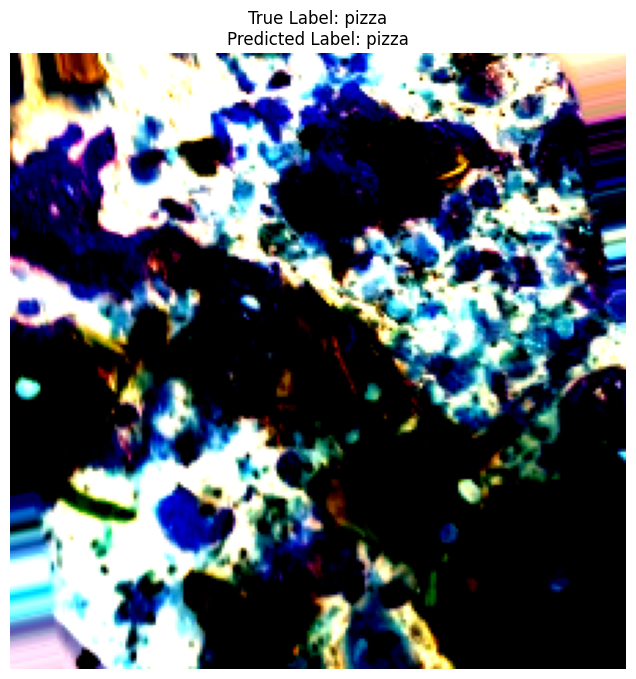

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def display_single_prediction(images, true_labels, predicted_labels, classes):

    # Select a random index from the dataset
    index = random.randint(0, len(images) - 1)

    # Get the image, true label, and predicted label
    image = images[index]
    true_label = true_labels[index]
    predicted_label = predicted_labels[index]

    # Display the original image with true and predicted labels
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)  # Use gray colormap for grayscale images
    plt.title(f'True Label: {classes[true_label]}\nPredicted Label: {classes[predicted_label]}')
    plt.axis('off')
    plt.show()

# Display one image with its true and predicted labels
display_single_prediction(X_test, y_test, predictions, classes)


In [ ]:
import joblib
joblib.dump(logistic, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']